In [1]:
import numpy as np
import pandas as pd

# import GPUtil
# #imports from python 3.8
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load


## Get NVIDIA GPU Details

Get the information about the graphics card on the system for CUDA acceleration.

In [5]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()

Wed May  8 18:42:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               4W /  55W |    244MiB /  4096MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## List available GPU's on the system 

In [2]:
# import torch
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print("Device: ",device)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # export CUDA_VISIBLE_DEVICES=0
# GPUtil.getAvailable()
# use_cuda = torch.cuda.is_available()
# if use_cuda:
#     print('__CUDNN VERSION:', torch.backends.cudnn.version())
#     print('__Number CUDA Devices:', torch.cuda.device_count())
#     print('__CUDA Device Name:',torch.cuda.get_device_name(0))
#     print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
# else:
#     print("None")


print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import sys
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print(sys.version)
tf.test.is_gpu_available()

Tensorflow version: 2.10.0
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Data Loading for ML

Here we load preprocessed data for a machine learning pipeline, which is a CNN model in our case.

In [2]:
df = pd.read_csv('./data/df_final.csv')

X_train = pd.read_csv('./data/X_train_final.csv')
Y_train = pd.read_csv('./data/Y_train_final.csv')
X_test = pd.read_csv('./data/X_test.csv')
Y_test = pd.read_csv('./data/Y_test.csv')
X_val = pd.read_csv('./data/X_val.csv')
Y_val = pd.read_csv('./data/Y_val.csv')

In [3]:
print("Train set shapes:", X_train.shape, Y_train.shape)
print("Test set shapes:", X_test.shape, Y_test.shape)
print("Validation set shapes:", X_val.shape, Y_val.shape)

Train set shapes: (48000, 1) (48000, 1)
Test set shapes: (16267, 1) (16267, 1)
Validation set shapes: (16267, 1) (16267, 1)


## Hyperparameter Configuration

Here we define hyperparameters for training a CNN model for image classification with 6 output classes.

**Hyperparameters:**

| Parameter | Value | Description |
|---|---|---|
| BATCH_SIZE | 100 | Amount of images processed in each training step. |
| INPUT_DIM | (150, 150, 3) | Stats of the input images (height, width, channels): RGB images with 3 channels (data is preprocessed). |
| OUTPUT_CLASSES | 6 | Number of output classes for the model. |
| EPOCHS | 32 | Number of times the entire training dataset is passed through the model during training. |
| LEARNING_RATE | 1e-2 (0.01) | Controls the step size used to update model weights during training. |
| MOMENTUM | 0.9 | Used in gradient descent optimization to accelerate convergence and improve stability. |

In [4]:
# Model Parameters
BATCH_SIZE = 100
INPUT_DIM = (150, 150, 3)  # RGB - 3 channels images
OUTPUT_CLASSES = 6  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 32
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

## Model Training: Image Data Augmentation and Generator Setup

Here we prepare data for training a CNN model using image data augmentation and generators in Keras/TensorFlow.

In [19]:
Y_val['Class'] = Y_val['Class'].astype(str)
merged_val_df = pd.concat([X_val, Y_val], axis=1)
merged_train_df = pd.concat([X_train, Y_train], axis=1)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest',
                               vertical_flip=False,
                               validation_split=0.3)
val_datagen = ImageDataGenerator(rescale=1./255)


# Flow from merged DataFrame with full image paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=merged_train_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
)

# Flow from merged DataFrame with full image paths
val_generator = val_datagen.flow_from_dataframe(
    dataframe=merged_val_df,
    # directory= df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 47999 validated image filenames belonging to 6 classes.


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


Found 16267 validated image filenames belonging to 6 classes.


In [62]:
X_test = pd.read_csv('./data/X_test.csv')
Y_test = pd.read_csv('./data/Y_test.csv')
merged_test_df = pd.concat([X_test, Y_test], axis=1)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=merged_test_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

Found 16267 validated image filenames belonging to 6 classes.


## CNN Model Definition and Compilation

Here we define and compiles a CNN model for image classification.

**Model Architecture:**

- **Sequential Model:** Model applicable for stacking layers one after another.
- **Convolutional Layers:** Three convolutional layers are used with ReLU activation:
     - First layer: Learns 32 filters of size 3x3, operating on the input image shape of (150, 150, 3) (height, width, channels).
     - Second layer: Learns 64 filters of size 3x3.
     - Third layer: Learns 128 filters of size 3x3.
- **Pooling Layers:** Max pooling layers of size 2x2 are applied after each convolutional layer to downsample the feature maps and reduce dimensionality.
- **Flatten Layer:** Flattens the output of the last convolutional layer into a 1D vector to feed into the dense layer.
- **Dense Layers:**
     - First hidden layer: Contains 512 neurons with ReLU activation for non-linearity.
     - Dropout layer: Introduces a 50% dropout rate to prevent overfitting.
- **Output Layer:** Contains 6 neurons with softmax activation for multi-class classification (one neuron per category).

**Model Compilation:**

- **Optimizer:** The model is compiled using the Adam optimizer with a learning rate of 0.001.
- **Loss Function:** Categorical crossentropy is used as the loss function, suitable for multi-class classification problems.
- **Metrics:** Accuracy is chosen as a metric to monitor the model's performance during training and evaluation.


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_categories = 6
model = tf.keras.Sequential([
        # Convolutional layer learning 32 filters with a kernel size of 3x3
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
        # Second convolutional layer with 64 filters
         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
         tf.keras.layers.MaxPooling2D(2, 2),
        # Third convolutional layer with 128 filters
         tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
         tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a DNN
         tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
         tf.keras.layers.Dense(512, activation='relu'),
         tf.keras.layers.Dropout(0.5),
        # Output layer with one neuron per category
         tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Train the model
log_dir = "./CNN/log_model1/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator,
        steps_per_epoch=100,  # depends on the size of your training set
        epochs=30,
        validation_data=val_generator,
        validation_steps=50)  # depends on the size of your validation set

# Save the model
model.save('model1.h5')


Epoch 1/30
100/100 [==============================] - 94s 934ms/step - loss: 1.5802 - accuracy: 0.3469 - val_loss: 1.3864 - val_accuracy: 0.5458
Epoch 2/30
100/100 [==============================] - 85s 853ms/step - loss: 1.2977 - accuracy: 0.4742 - val_loss: 0.9701 - val_accuracy: 0.6460
Epoch 3/30
100/100 [==============================] - 83s 828ms/step - loss: 1.1575 - accuracy: 0.5381 - val_loss: 1.0316 - val_accuracy: 0.6560
Epoch 4/30
100/100 [==============================] - 83s 824ms/step - loss: 1.0754 - accuracy: 0.5820 - val_loss: 0.8088 - val_accuracy: 0.7062
Epoch 5/30
100/100 [==============================] - 106s 1s/step - loss: 1.0131 - accuracy: 0.6084 - val_loss: 0.7790 - val_accuracy: 0.7236
Epoch 6/30
100/100 [==============================] - 114s 1s/step - loss: 0.9421 - accuracy: 0.6461 - val_loss: 0.6637 - val_accuracy: 0.7656
Epoch 7/30
100/100 [==============================] - 103s 1s/step - loss: 0.9042 - accuracy: 0.6576 - val_loss: 0.6626 - val_accuracy

In [ ]:
## Plotting the results

In [5]:
def plot_learning_curve(
        train_loss, val_loss, train_metric, val_metric,
        to_file: str = None
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, 'r--')
    ax[0].plot(val_loss, 'b--')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(['train', 'val'])

    ax[1].plot(train_metric, 'r--')
    ax[1].plot(val_metric, 'b--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].axhline(y=0.125, c='g', alpha=0.5)  # Random probability - naive classifier
    ax[1].legend(['train', 'val', 'random baseline'])

    fig.tight_layout()
    plt.show()
    if to_file is not None:
        fig.savefig(to_file)

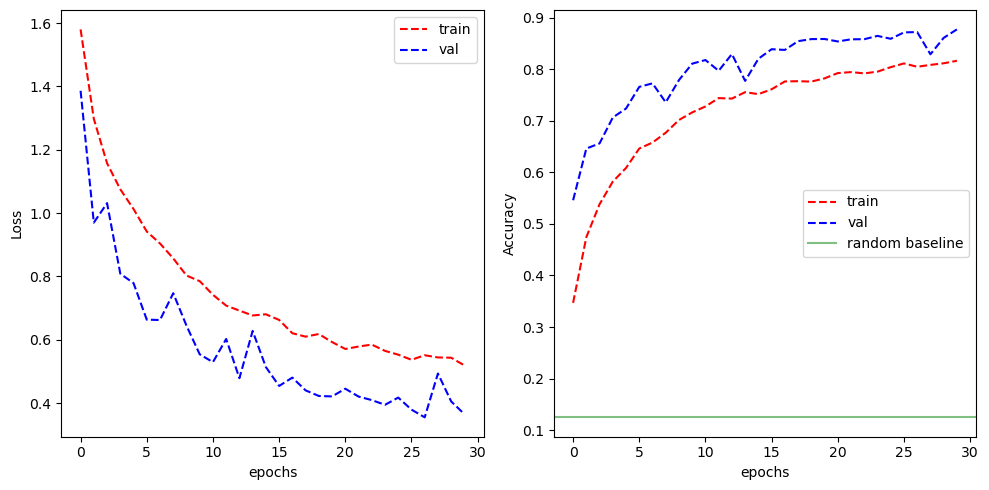

In [59]:
plot_name = 'clf-cnn1'
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['accuracy'],
    history.history['val_accuracy'],
    to_file=f'images/{plot_name}-LearningCurve.png'
)

In [ ]:
## Loading the model from a file to avoid recomputation

In [63]:
model1 = tf.keras.models.load_model('model1.h5')
with tf.device('GPU:0'):
    # Evaluate the model on the test data using the test generator
    loss, accuracy = model1.evaluate(test_generator, steps=len(test_generator))
    
    # Print the test accuracy
    print('Test accuracy:', accuracy)

16267/16267 [==============================] - 65s 4ms/step - loss: 0.3722 - accuracy: 0.8761
Test accuracy: 0.8761295676231384


## Model 2

The difference between Model 2 and Model 1 is that the number of filters varies across the convolutional layers and there is only one dense layer with a fixed number of neurons.

Motivation behind that is to enhance the model's capacity to capture patterns in the data, improve generalization performance, and provide better control over the optimization process.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_categories = 6
model2 = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(32, (3, 3), padding='same',strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
     
         tf.keras.layers.Conv2D(64, (3, 3), padding='same',strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
    
         tf.keras.layers.Conv2D(128, (3, 3), padding='same',strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
         tf.keras.layers.MaxPooling2D(2, 2),
    
        # flatten the layer before feeding into the dense layer #
         tf.keras.layers.Flatten(),
        # dense layer together with dropout to prevent overfitting #
         tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_normal'),
        tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer='he_normal'),
        tf.keras.layers.Dense(units=32,activation='relu',kernel_initializer='he_normal'),
         tf.keras.layers.Dropout(0.5),
        # Output layer with one neuron per category
         tf.keras.layers.Dense(num_categories, activation='softmax')
    ])
    
# Compile the model
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 18, 18, 128)     

In [32]:
# Train the model with new data sets and model1
log_dir = "CNN_log4/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model2.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator)  
# Save the model
model2.save('model4.h5')

Epoch 1/32
480/480 [==============================] - 372s 775ms/step - loss: 1.3979 - accuracy: 0.4131 - val_loss: 1.0264 - val_accuracy: 0.6395
Epoch 2/32
480/480 [==============================] - 334s 696ms/step - loss: 1.1326 - accuracy: 0.5639 - val_loss: 0.7033 - val_accuracy: 0.7492
Epoch 3/32
480/480 [==============================] - 373s 776ms/step - loss: 0.9308 - accuracy: 0.6644 - val_loss: 0.5472 - val_accuracy: 0.8122
Epoch 4/32
480/480 [==============================] - 363s 755ms/step - loss: 0.7973 - accuracy: 0.7231 - val_loss: 0.4828 - val_accuracy: 0.8329
Epoch 5/32
480/480 [==============================] - 384s 800ms/step - loss: 0.7057 - accuracy: 0.7587 - val_loss: 0.4630 - val_accuracy: 0.8369
Epoch 6/32
480/480 [==============================] - 377s 785ms/step - loss: 0.6466 - accuracy: 0.7815 - val_loss: 0.4234 - val_accuracy: 0.8568
Epoch 7/32
480/480 [==============================] - 385s 802ms/step - loss: 0.6136 - accuracy: 0.7951 - val_loss: 0.4133 -

In [12]:
# Save history
dump(history, 'history_model4.pkl')

['history_model4.pkl']

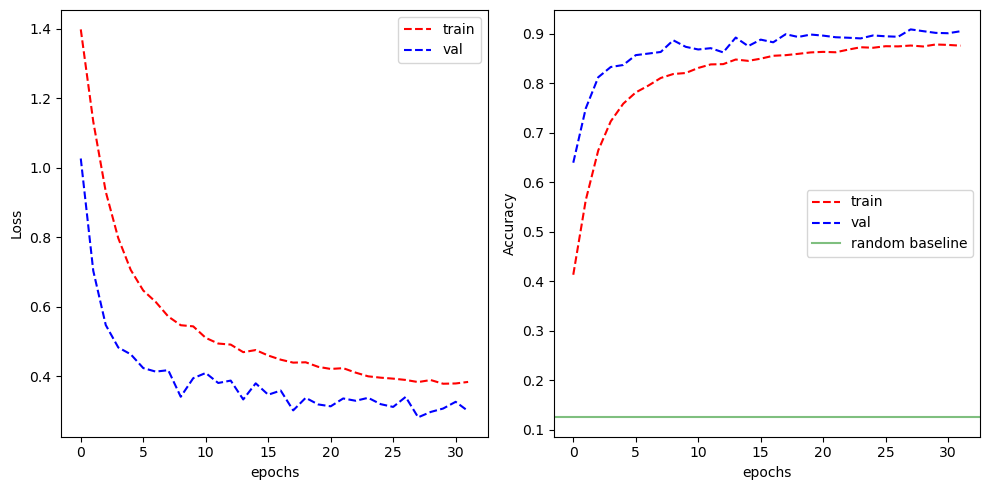

In [13]:
# Load history
history = load('history_model4.pkl')
plot_name = 'clf-cnn4'
plot_learning_curve(
    history['loss'],
    history['val_loss'],
    history['accuracy'],
    history['val_accuracy'],
    to_file=f'images/{plot_name}-LearningCurve.png'
)

In [38]:
with tf.device('GPU:0'):
    # Evaluate the model on the test data using the test generator
    loss, accuracy = model2.evaluate(test_generator, steps=len(test_generator))
    
    # Print the test accuracy
    print('Test accuracy:', accuracy)

16267/16267 [==============================] - 119s 7ms/step - loss: 0.2995 - accuracy: 0.9045
Test accuracy: 0.9044691920280457


The attempt to improve of the model, unfortunately, did not work. The reason of that may be overfitting and poor hyperparameter choice. 

## Visualize random images

In this snippet we will choose 10 random pictures and classify their furniture type.

1/1 [==============================] - 0s 18ms/step


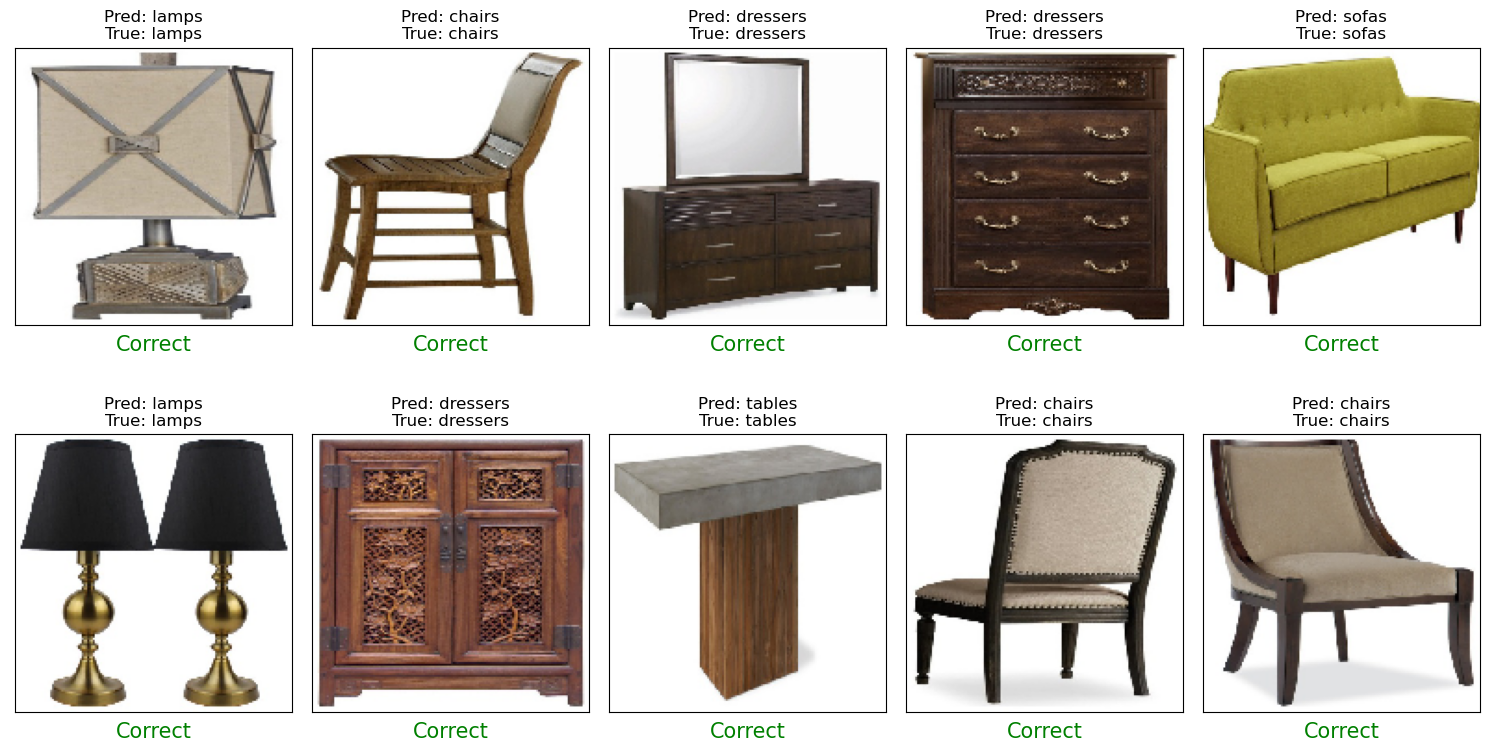

In [66]:
# Fetch 10 random batches from the test generator
random_images = []
random_truths = []
random_predictions = []
model = tf.keras.models.load_model('model2.h5')

for i in range(10):
    # Obtain a batch (since batch_size=1, this is one image)
    img, truth = next(test_generator)
    pred = model.predict(img)
    pred_label = np.argmax(pred, axis=1)  # Get the predicted class index
    
    # Store the data
    random_images.append(img[0])  # img[0] because batch_size=1
    random_truths.append(truth[0])  # Same as above
    random_predictions.append(pred_label[0])  # Decode the prediction

# If you have class indices to label mapping
label_map = {v: k for k, v in test_generator.class_indices.items()}
random_truth_labels = [label_map[np.argmax(t)] for t in random_truths]
random_pred_labels = [label_map[p] for p in random_predictions]

plt.figure(figsize=(15, 8))
plt.rc('axes', labelsize=15)  
for i, (image, truth, pred) in enumerate(zip(random_images, random_truth_labels, random_pred_labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {pred}\nTrue: {truth}")
    plt.xlabel("Correct" if pred == truth else "Incorrect", color="green" if pred == truth else "red")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

From the picture above we can tell that the classification part works well in our model. Therefore, we may continue with querying images now.

## Image Query

In this snippet we are going to load a picture from a user and classify it's category. 
After the picture is loaded, it undergoes the same processing steps as all the pictures in the dataset such as RGB value normalization.

In [3]:
model = tf.keras.models.load_model('model4.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 18, 18, 128)     

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2

def predict_single_image(image_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    
    # # Load the model if given as a path
    # if isinstance(model, str):
    #     model = load_model(model)

    # Predict the class
    prediction = model.predict(img_array)
    print(prediction)
    predicted_class = np.argmax(prediction, axis=1)
    print(predicted_class)

    # Optionally, decode the predictions
    # Assuming you have a mapping of class indices to labels
    class_labels = {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
    predicted_label = class_labels[predicted_class[0]]

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

    return predicted_label


1/1 [==============================] - 5s 5s/step
[[3.0410781e-03 5.8537949e-04 9.9466276e-01 5.3889155e-05 5.0471822e-04
  1.1522351e-03]]
[2]


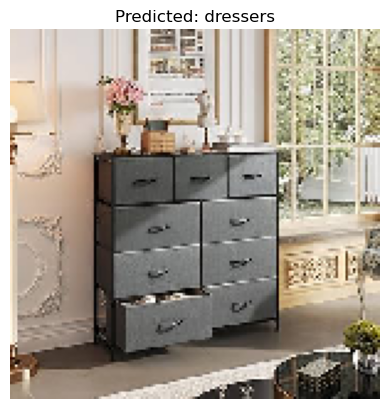

Predicted Label: dressers


In [16]:
image_path = './query_image/dresser.jpg'
# model = tf.keras.models.load_model('model1.h5')
# Call the function
predicted_label = predict_single_image(image_path, model)
print("Predicted Label:", predicted_label)


As we can see on the picture above, classification went successful.